In [1]:
from typing import Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from scipy.optimize import curve_fit
from scipy.stats import rv_continuous
import plotly.graph_objects as go
from tqdm import tqdm

rng = np.random.default_rng()

DATA_FOLDER = Path("../data").resolve()
OUTPUT_FOLDER = Path("../output").resolve()

In [2]:
def power_law(x: np.array, a: float, b: float) -> np.array:
    return a * np.power(x, b)


def show_fit(x: pd.Series, y: pd.Series, pars: Tuple[float, float]):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(x, y, color="#00b3b3", label="Data")
    ax.plot(x, power_law(x, *pars), linestyle="--", linewidth=2, color="green")
    fig.show()


class FittedPowerlaw(rv_continuous):
    def __init__(self, x: pd.Series, y: pd.Series):
        super().__init__(a=0)
        self.pars, self.cov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0])

    def _pdf(self, x: np.array) -> np.array:
        a, b = self.pars
        return power_law(x, a, b)

    def show_sample(self):
        sample = pd.DataFrame(self.rvs(size=2000))
        return sample.plot.hist(bins=50)


In [3]:
def split(df, divide):
    l = []
    for i, d in enumerate([x[1] for x in df.resample(f"{1440//divide}min", on="datetime")]):
        l.append(d.assign(datetime=i))
    return pd.concat(l)

In [4]:
def group_exposures(df:pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
    # meetings per person per day
    # df = split(df,2)
    df["datetime"] = df["datetime"].dt.floor("d")
    df = df.append(
        df.rename(columns={"source": "destination", "destination": "source"})
    ).reset_index(drop=True)
    df = (
        df.groupby(["source", "datetime"])["destination"]
        .size()
        .reset_index(drop=True)
        .value_counts(normalize=True)
        .sort_index()
        .reset_index()
    ).rename(
        columns={
            "destination": "count_of_people_normalized",
            "index": "how_many_people_they_met_in_a_day",
        }
    )
    x = df["how_many_people_they_met_in_a_day"]
    y = df["count_of_people_normalized"]
    return x, y

In [5]:
def group_durations(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    df = (
        df["duration"]
        .value_counts(normalize=True)
        .reset_index()
        .rename(
            columns={"index": "meeting_duration", "duration": "duration_normalized"}
        )
        .sort_values("meeting_duration")
    )
    a = df["meeting_duration"].to_numpy()
    p = df["duration_normalized"].to_numpy()
    return a, p

<AxesSubplot:ylabel='Frequency'>

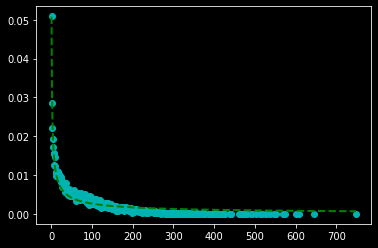

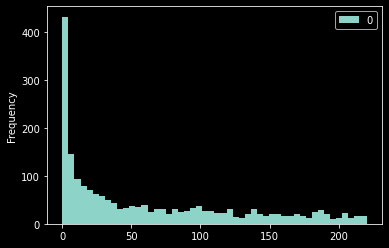

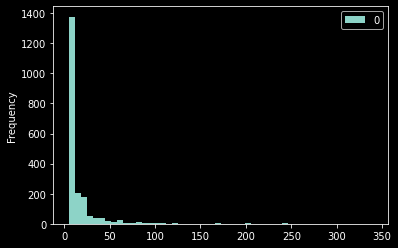

In [6]:
df = pd.read_csv(DATA_FOLDER / "copenhagen_agg.csv", parse_dates=["datetime"])
a, p = group_durations(df)
x, y = group_exposures(df)
meetings_fitted_powerlaw = FittedPowerlaw(x, y)
show_fit(x, y, meetings_fitted_powerlaw.pars)
meetings_fitted_powerlaw.show_sample()
pd.DataFrame(rng.choice(a, p=p, size=2000)).plot.hist(bins=50)


In [7]:
def mult(s: np.array, D_min: int, P_max: float, D_max: int) -> float:
    s = np.where(s >= D_min, s, 0.00001)
    res = 1 - np.prod(1 - np.minimum(s / D_max, 1) * P_max)
    return res


def random_meetings(
    a: np.array, p: np.array, fp: FittedPowerlaw, dmin: int, dmax: int, pmax: float
) -> Tuple[int, int, float]:
    x = int(np.floor(fp.rvs(size=1)[0]))
    durations = rng.choice(a, p=p, size=x)
    y = sum(durations)
    z = mult(durations, D_min=dmin, P_max=pmax, D_max=dmax)
    return x, y, z


In [11]:
params = {"dmin": 0, "dmax": 1440, "pmax": 1}
iter_ = 1000
vdf = []
for param in range(0, 11, 2):
    param = param / 10
    params["pmax"] = param
    vdf.append(pd.DataFrame(
        [
            random_meetings(a, p, meetings_fitted_powerlaw, **params)
            for _ in tqdm(range(iter_))
        ],
        columns=list("xyz"),
    ).assign(param=param))
vdf = pd.concat(vdf)
# vdf["param"] = vdf["param"] / 10
# pstring = "_".join([k + "_" + str(v) for k, v in params.items()])
# vdf.to_csv(DATA_FOLDER / f"numerical_analysis_{pstring}_iter_{iter_}.csv", index=False)


100%|██████████| 1000/1000 [00:35<00:00, 28.32it/s]


In [36]:
vdf = vdf.sort_values("param", ascending=False)

In [11]:
# np.corrcoef(vdf["z"], vdf["x"])
np.cov(vdf["x"]/max(vdf["x"]), vdf["y"]/max(vdf["y"]))
# np.cov(vdf["x"]/max(vdf["x"]), vdf["z"])

array([[0.08249079, 0.06004074],
       [0.06004074, 0.04581195]])

In [12]:
# vdf = pd.read_csv(DATA_FOLDER / "numerical_analysis_dmin_0_dmax_1440_pmax_1_iter_1000.csv")

[Fit 3D line](https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d)

In [13]:
import plotly.express as px
colorscale = [
    [0.0, "rgb(33,102,172)"],
    [0.33333333333, "rgb(146, 197, 222)"],
    [0.8, "rgb(214, 96, 77)"],
    [1.0, "rgb(178, 24, 43)"],
]

rev_colorscale = [
    [0.0, "rgb(178, 24, 43)"],
    [0.33333333333, "rgb(214, 96, 77)"],
    [0.8, "rgb(146, 197, 222)"],
    [1.0, "rgb(33,102,172)"],
]

# # vdf["param"] = vdf["param"] / 10

data = go.Scatter3d(
    x=vdf["x"],
    y=vdf["y"],
    z=vdf["z"],
    mode="markers",
    marker=dict(
        size=3,
        color=vdf["param"],
        colorscale=px.colors.sequential.Plasma_r,
        colorbar=dict(thickness=10, lenmode="fraction", len=0.5, title="Dmin"),
    ),
    opacity=0.8,
)
fig = go.Figure(data)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0), font_family="Arial, Helvetica, sans-serif"
)
fig.update_layout(
    scene=dict(
        xaxis_title="Number of people exposed to per day",
        yaxis_title="Summed exposure duration",
        zaxis_title="Infection probability",
        xaxis=dict(backgroundcolor="rgb(240,240,240)"),
        yaxis=dict(backgroundcolor="rgb(240,240,240)"),
        zaxis=dict(backgroundcolor="rgb(240,240,240)"),
    )
)

# fig.update_layout(coloraxis_showscale=True)
# fig.show()
fig.write_html(OUTPUT_FOLDER / "xyz_pmax.html")


In [ ]:
chart = alt.Chart(vdf).mark_point().encode(
    x=alt.X('x:Q', title="Number of people exposed to per day"),
    y=alt.Y('y:Q', title="Summed exposure duration"),
    color=alt.Color('z:Q', title="Infection probability")
)
chart.save(str(OUTPUT_FOLDER / "numerical_analysis.html"), format="html")
# chart